In [1]:
# Impacto de Factores Climáticos en la Producción y Consumo de Energíam
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("historical_weather.csv")
df.datetime = pd.to_datetime(df.datetime)
df = df.loc[df.datetime.dt.year == 2022]
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf.set_crs(epsg=4326)
gdf = gdf.groupby([gdf.datetime.dt.day_of_year, gdf.geometry]).agg({"temperature":("mean"), "rain":("mean"), "cloudcover_total":("mean"), "snowfall":("mean")})
gdf = gpd.GeoDataFrame(gdf.reset_index())
gdf.head()


,datetime,geometry,temperature,rain,cloudcover_total,snowfall
0,1,POINT (21.70000 57.60000),1.066667,0.016667,72.791667,0.0
1,1,POINT (22.20000 57.60000),0.691667,0.008333,73.333333,0.0
2,1,POINT (21.70000 57.90000),0.241667,0.012500,71.125000,0.0
3,1,POINT (22.20000 57.90000),0.650000,0.012500,71.125000,0.0
4,1,POINT (22.70000 57.90000),-0.391667,0.041667,70.916667,0.0


In [3]:
gdf.geometry.value_counts()

geometry
POINT (21.70000 57.60000)    365
POINT (22.20000 57.60000)    365
POINT (21.70000 57.90000)    365
POINT (22.20000 57.90000)    365
POINT (22.70000 57.90000)    365
                            ... 
POINT (27.20000 57.90000)    365
POINT (27.70000 57.90000)    365
POINT (28.20000 57.90000)    365
POINT (27.70000 57.60000)    365
POINT (28.20000 57.60000)    365
Name: count, Length: 112, dtype: int64

<Axes: >

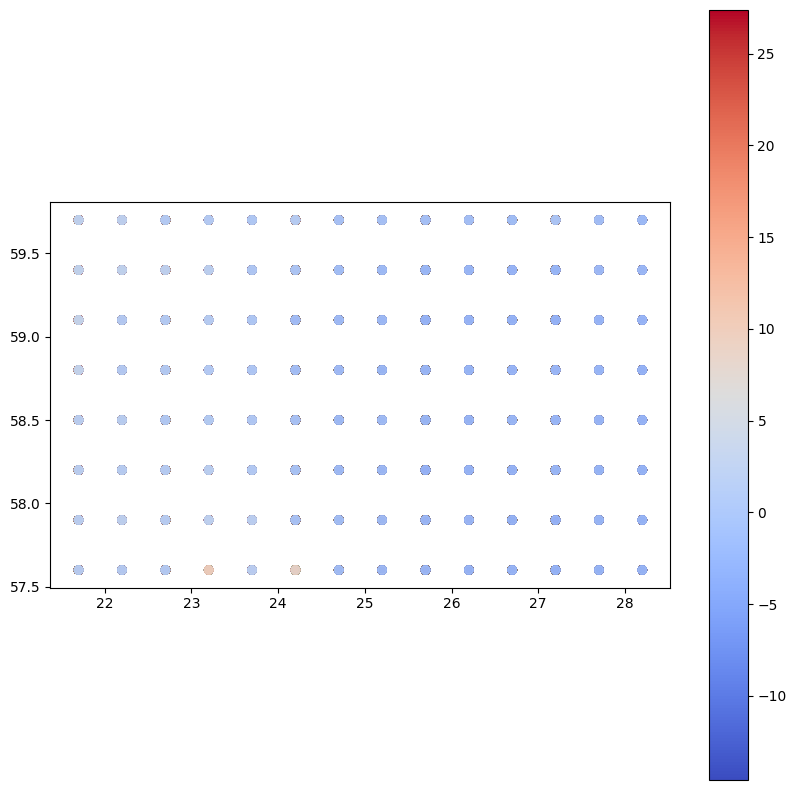

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))


gdf.plot(column = "temperature", cmap="coolwarm", legend=True, ax=ax, alpha = 0.1)

<Axes: ylabel='Frequency'>

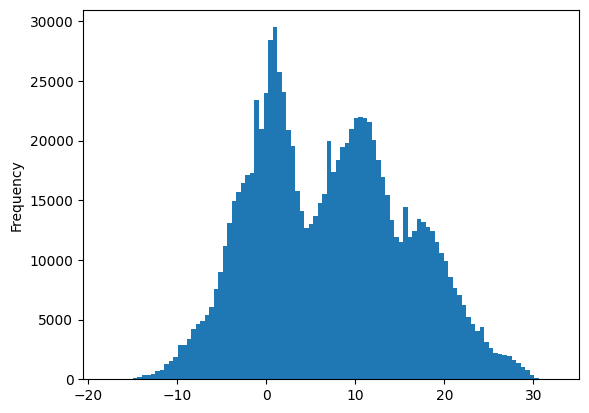

In [5]:
df.temperature.plot.hist(bins = 100)

<Axes: ylabel='Frequency'>

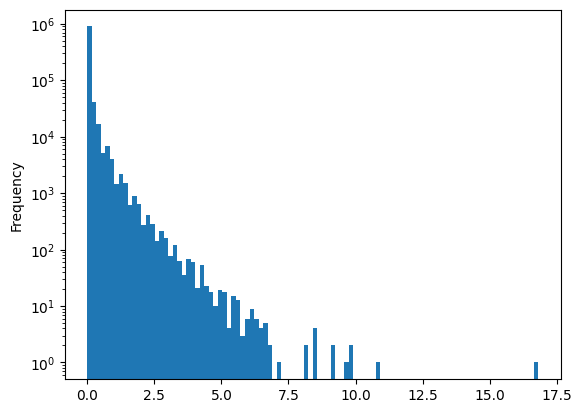

In [6]:
df.rain.plot.hist(bins = 100, log = True)

<Axes: ylabel='Frequency'>

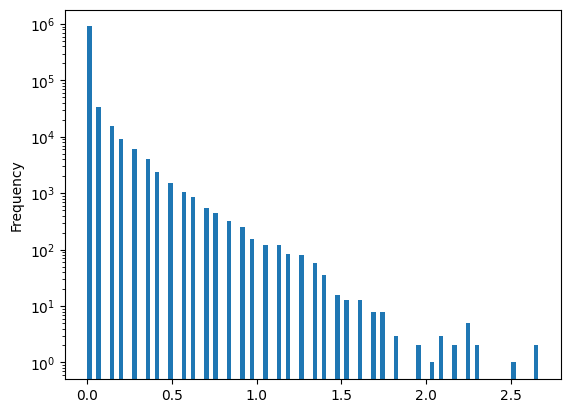

In [7]:
#log scale
df.snowfall.plot.hist(bins = 100, log = True)

<Axes: ylabel='Frequency'>

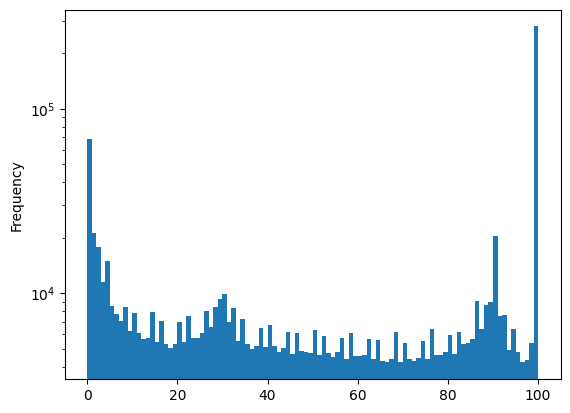

In [8]:
df.cloudcover_total.plot.hist(bins = 100, log = True)

In [9]:
SNOW_MID = gdf.loc[gdf.snowfall > 0, "snowfall"].quantile(0.33)
SNOW_HIGH = gdf.loc[gdf.snowfall > 0, "snowfall"].quantile(0.66)


def get_weather_summary(row):
    summary = ""
    summary += f"{round(row.temperature)}ºC"
    if 15 > row.rain >= 2:
        summary +="🌦️"
    elif 30 > row.rain >= 15:
        summary +="🌧️"
    elif row.rain >= 30:
        summary +="⛈️"

    if SNOW_MID > row.snowfall > 0:
        summary += "❄️"
    elif SNOW_HIGH > row.snowfall >= SNOW_MID:
        summary += "❄️❄️"
    elif row.snowfall >= SNOW_HIGH:
        summary += "❄️❄️❄️"

    if row.cloudcover_total < 30:
        summary += "☀️"
    elif 60 > row.cloudcover_total >= 30:
        summary += "🌤️"
    elif 90 > row.cloudcover_total >= 60:
        summary += "⛅"
    elif row.cloudcover_total >= 90:
        summary += "☁️"

        
    return summary

gdf["weather_summary"] = gdf.apply(get_weather_summary, axis = 1)

In [10]:
gdf.weather_summary.value_counts()

weather_summary
10ºC⛅           966
11ºC⛅           929
12ºC⛅           691
9ºC⛅            689
10ºC🌤️          560
               ... 
0ºC❄️❄️☀️         1
6ºC❄️⛅            1
6ºC❄️❄️⛅          1
-3ºC❄️❄️❄️🌤️      1
-9ºC❄️❄️🌤️        1
Name: count, Length: 300, dtype: int64

In [11]:
 gdf.geometry.y.mean()

np.float64(58.65)

In [12]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import json

# Cargar los datos
# weather_data = pd.read_csv('historical_weather.csv')
estonia_map = gpd.read_file('shapefiles/ee.shp')

# # Mapear tipo de tiempo a emojis
# weather_emoji_map = {
#     'sunny': '☀️',
#     'rainy': '🌧️',
#     'cloudy': '☁️',
#     # Añadir otros tipos de tiempo según tus datos
# }

# # Función para obtener el emoji correspondiente
# def get_weather_emoji(weather_type):
#     return weather_emoji_map.get(weather_type, '❓')

# # Agregar emojis a los datos meteorológicos
# weather_data['weather_emoji'] = weather_data['weather_type'].apply(get_weather_emoji)

# Configurar la aplicación Dash
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='weather-map'),
    dcc.Slider(
        id='day-slider',
        min=gdf.datetime.min(),
        max=gdf.datetime.max(),
        value=gdf.datetime.min(),
        marks={str(day): str(day) for day in range(gdf.datetime.min(), gdf.datetime.max() + 1)}
    )
])

@app.callback(
    Output('weather-map', 'figure'),
    [Input('day-slider', 'value')]
)
def update_map(selected_day):
    filtered_data = gdf[gdf.datetime == selected_day]

    fig = px.choropleth_mapbox(
        # geojson=json.loads(estonia_map.to_json()),
        locations=filtered_data.geometry,
        featureidkey="properties.station",
        color=filtered_data.weather_summary,
        mapbox_style="carto-positron",
        center={"lat": gdf.geometry.y.mean()[0], "lon":  gdf.geometry.x.mean()[0]},
        zoom=6
    )
    
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)
